Stock prediction using RNN - LSTM

In [271]:
#imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn



START_DATE ="1900-01-01"
END_DATE = "2024-01-01"

STOCKS_FOLDER = "stocks"
MACROECOMOMIC_US_FOLDER = "macroeconomic_us"
MACROECOMOMIC_GLOBAL_FOLDER = "macroeconomic_global"
COMMODITY_FOLDER = "commodity"

#load dataset
dataset = pd.read_csv("Train_Data/data.csv")
dataset = dataset[['Date', 'Close']]
dataset.head()

,Date,Close
0,1992-01-30 00:00:00-05:00,3244.899902
1,1992-01-31 00:00:00-05:00,3223.399902
2,1992-02-03 00:00:00-05:00,3234.100098
3,1992-02-04 00:00:00-05:00,3272.800049
4,1992-02-05 00:00:00-05:00,3257.600098


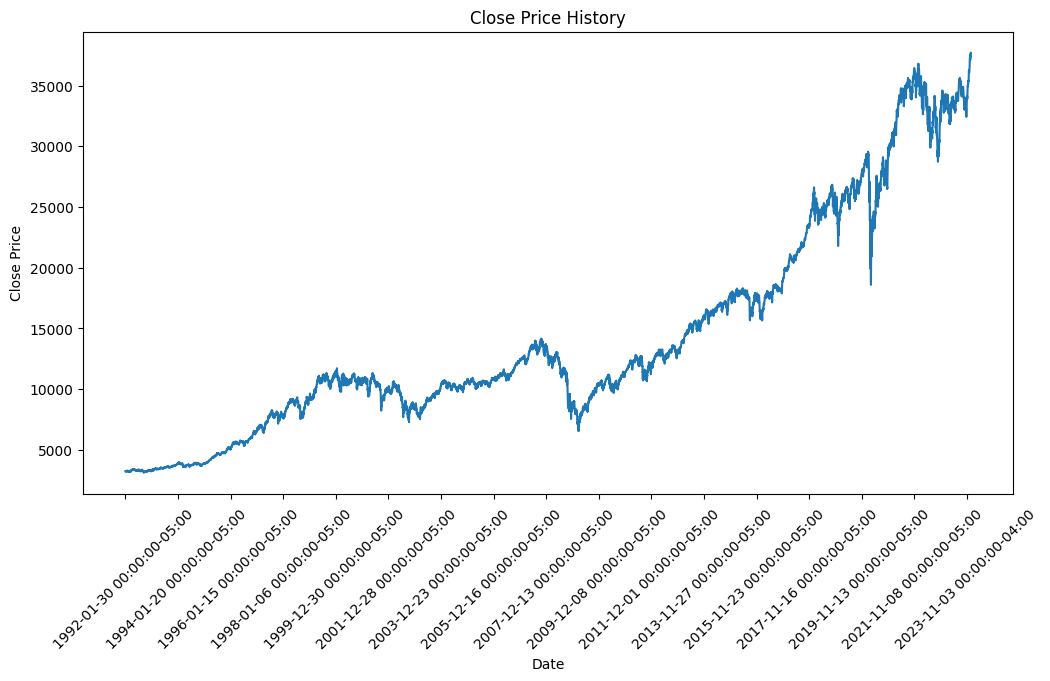

In [272]:
#plot dataset
import matplotlib.pyplot as plt

def plot_dataset(dataset):
    plt.figure(figsize=(12,6))
    plt.plot(dataset['Close'])
    plt.xticks(range(0,dataset.shape[0],500),dataset['Date'].loc[::500],rotation=45)
    plt.title('Close Price History')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()

plot_dataset(dataset)


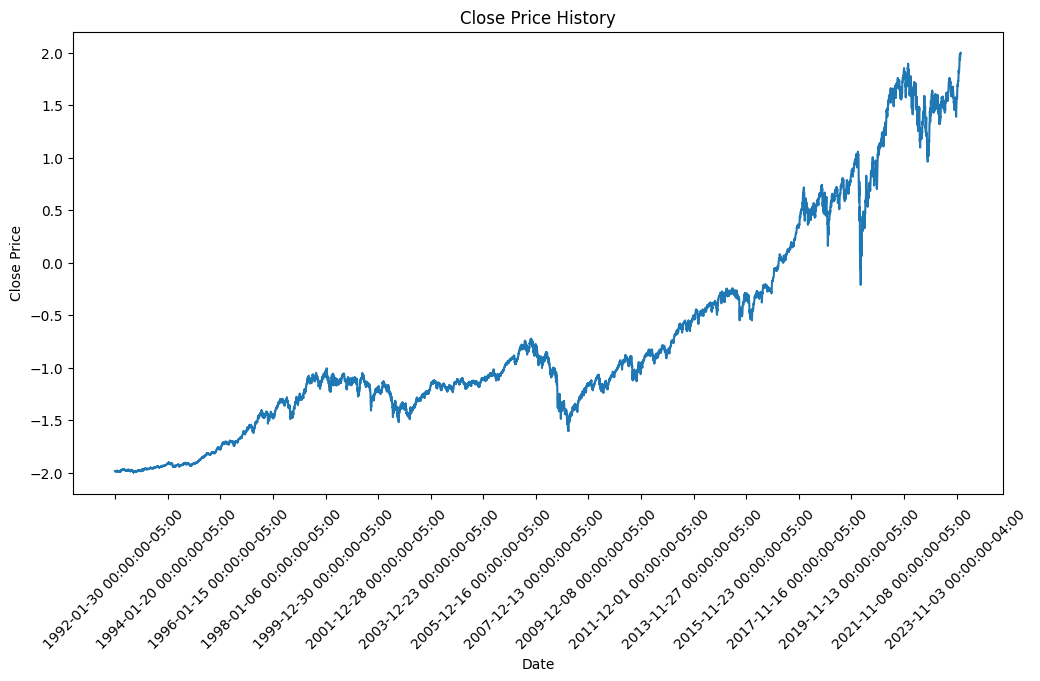

In [273]:
#Data normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-2,2))
dataset['Close'] = scaler.fit_transform(np.array(dataset['Close']).reshape(-1,1))

plot_dataset(dataset)

Create sequences for train and test

In [274]:
SPLIT_RATIO = 0.05

In [275]:
def split_data(stock, SEQ_LEN):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - SEQ_LEN): 
        data.append(data_raw[index: index + SEQ_LEN])
    
    data = np.array(data)
    test_set_size = int(np.round(SPLIT_RATIO*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [276]:
price = dataset[['Close']]

In [277]:
SEQ_LEN = 40
x_train, y_train, x_test, y_test = split_data(price, SEQ_LEN)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (7599, 39, 1)
y_train.shape =  (7599, 1)
x_test.shape =  (400, 39, 1)
y_test.shape =  (400, 1)


In [278]:
#Tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)

y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

LSTM

In [279]:
INPUT_DIM = 1
HIDDEN_DIM = 32
NUM_LAYERS = 2
OUTPUT_DIM = 1
NUM_EPOCHS = 100

In [280]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x,):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out


In [281]:
model = LSTM(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM, num_layers=NUM_LAYERS)
criterion = torch.nn.HuberLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [282]:
# training loop
import time


def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} took {end_time - start_time:.4f} seconds")
        return result
    return wrapper

@timer
def train_lstm():
    hist = np.zeros(NUM_EPOCHS)
    for t in range(NUM_EPOCHS):
        y_train_pred = model(x_train)
        loss = criterion(y_train_pred, y_train)
        print("Epoch ", t, "loss: ", loss.item())
        hist[t] = loss.item()

        optimiser.zero_grad()
        loss.backward()  # Retain the computational graph
        optimiser.step()


    #plot loss
    plt.plot(hist, label="Training loss")
    plt.legend()
    plt.show()

    return y_train_pred
    

Epoch  0 loss:  0.6841025948524475
Epoch  1 loss:  0.5544860363006592
Epoch  2 loss:  0.36348411440849304
Epoch  3 loss:  0.2035197615623474
Epoch  4 loss:  0.34285038709640503
Epoch  5 loss:  0.19779625535011292
Epoch  6 loss:  0.120631642639637
Epoch  7 loss:  0.12983931601047516
Epoch  8 loss:  0.1331169158220291
Epoch  9 loss:  0.10517570376396179
Epoch  10 loss:  0.06401538848876953
Epoch  11 loss:  0.04198862612247467
Epoch  12 loss:  0.05150284990668297
Epoch  13 loss:  0.0711856484413147
Epoch  14 loss:  0.07806415855884552
Epoch  15 loss:  0.06883344799280167
Epoch  16 loss:  0.05320393294095993
Epoch  17 loss:  0.041229214519262314
Epoch  18 loss:  0.036862097680568695
Epoch  19 loss:  0.03823840245604515
Epoch  20 loss:  0.04094180464744568
Epoch  21 loss:  0.041253216564655304
Epoch  22 loss:  0.03790669143199921
Epoch  23 loss:  0.0320972241461277
Epoch  24 loss:  0.026303233578801155
Epoch  25 loss:  0.022610655054450035
Epoch  26 loss:  0.021292883902788162
Epoch  27 los

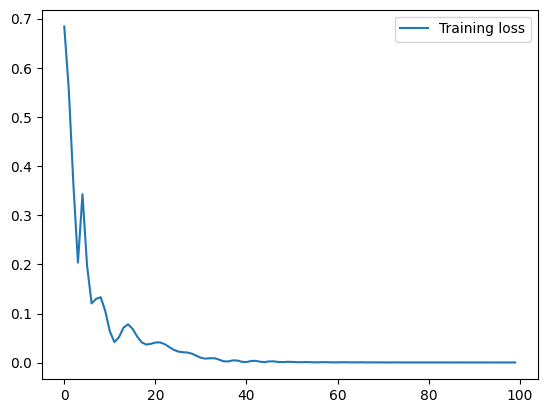

train_lstm took 40.9963 seconds


In [283]:
#train lstm
lstm_train_pred = train_lstm()

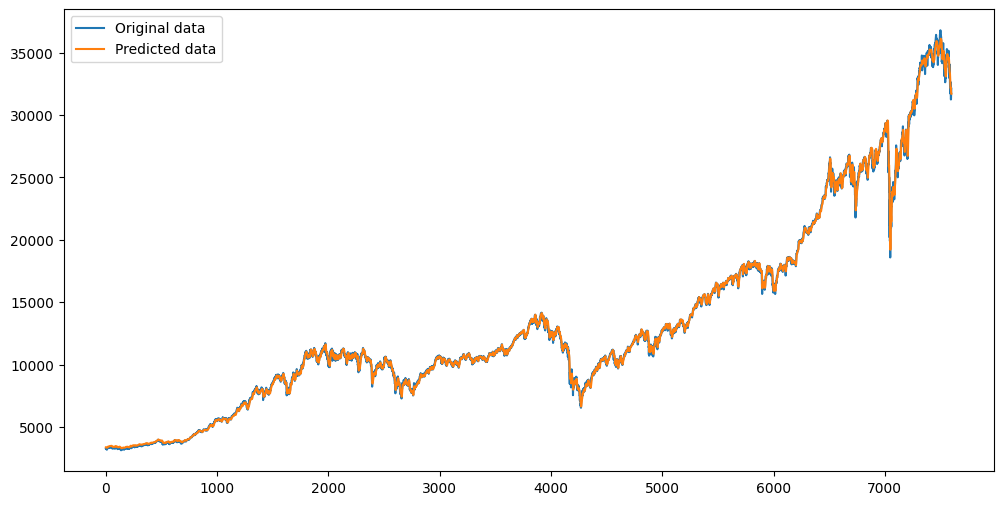

In [284]:
# compare predictions with targets
predict = pd.DataFrame(scaler.inverse_transform(lstm_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))

#plot prediction and original
plt.figure(figsize=(12,6))
plt.plot(original, label='Original data')
plt.plot(predict, label='Predicted data')
plt.legend()
plt.show()

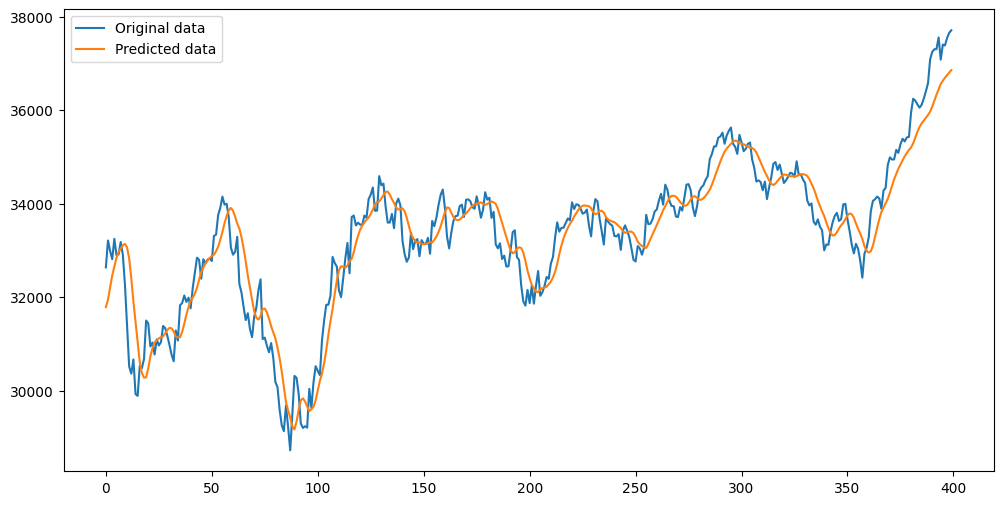

In [285]:
lstm_y_test_pred = model(x_test)

# scale test data back to original range
y_test = scaler.inverse_transform(y_test.detach().numpy())
lstm_y_test_pred = scaler.inverse_transform(lstm_y_test_pred.detach().numpy())

y_train = scaler.inverse_transform(y_train.detach().numpy())
lstm_train_pred = scaler.inverse_transform(lstm_train_pred.detach().numpy())

#plot prediction and original
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Original data')
plt.plot(lstm_y_test_pred, label='Predicted data')
plt.legend()
plt.show()



Predicted value: 1.307412028312683
Predicted value: 1.3086073398590088
Predicted value: 1.3103630542755127
Predicted value: 1.3125486373901367
Predicted value: 1.3151060342788696
Predicted value: 1.3179854154586792
Predicted value: 1.3211394548416138
Predicted value: 1.3245211839675903
Predicted value: 1.328088641166687
Predicted value: 1.3318040370941162
Predicted value: 1.3356328010559082
Predicted value: 1.3395451307296753
Predicted value: 1.3435176610946655
Predicted value: 1.347529649734497
Predicted value: 1.351563572883606
Predicted value: 1.3556060791015625
Predicted value: 1.359646201133728
Predicted value: 1.3636740446090698
Predicted value: 1.3676799535751343
Predicted value: 1.371658205986023
Predicted value: 1.3756026029586792
Predicted value: 1.3795086145401
Predicted value: 1.3833743333816528
Predicted value: 1.3871952295303345
Predicted value: 1.390970230102539
Predicted value: 1.3946971893310547
Predicted value: 1.39837646484375
Predicted value: 1.4020057916641235
Pred

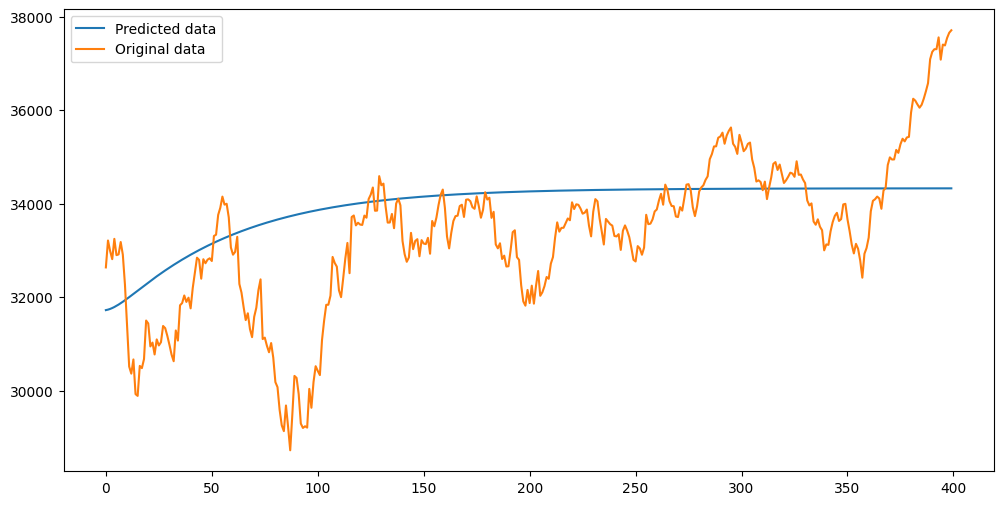

In [286]:
#rolling prediction
DAYS = y_test.shape[0]

last_train_seq = x_train[-1]

def roll_predictions(last_train_seq, days):
    preds = []
    last_train_seq = last_train_seq

    for _ in range(days):
        last_train_seq = last_train_seq.reshape(1, SEQ_LEN-1, 1)

        pred = model(last_train_seq)
        preds.append(pred.item())
        last_train_seq = torch.cat((last_train_seq.squeeze(0)[1:], pred)).unsqueeze(0)

        print(f'Predicted value: {pred.item()}')

    return preds

preds = roll_predictions(last_train_seq, DAYS)

print(preds)

#Scale back
preds = scaler.inverse_transform(np.array(preds).reshape(-1,1))

#plot prediction and original
plt.figure(figsize=(12,6))
plt.plot(preds, label='Predicted data')
plt.plot(y_test, label='Original data')
plt.legend()
plt.show()


